# Demo single-site trace

author: laquitainesteeve@gmail.com  

execution time: 1 min

## Setup

Create and activate `demo` virtual environment kernel `demo` from (envs/demo.yml)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface.extractors as se
import spikeinterface
from matplotlib import pyplot as plt;
print("spikeinterface", spikeinterface.__version__)

# dandiset parameters
dandiset_id = '001250'
filepath = 'sub-demo-npx-bio-evoked/sub-demo-npx-bio-evoked_ecephys.nwb'

# project path
proj_path = "/Users/steeve_laquitaine/Desktop/EPFL/2022_2024_bbp/spikebias/"
# proj_path = "/home/jovyan/steevelaquitaine/spikebias/"
os.chdir(proj_path)

# import spikebias
from src.nodes.validation import noise

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/steeve_laquitaine/Desktop/EPFL/2022_2024_bbp/spikebias/envs/demo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


spikeinterface 0.101.2


## Load demo

In [ ]:
%%time

# get the extractors from Dandi archive
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
Recording = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile")

# load voltage traces 
traces = Recording.get_traces()

# report info
print("s3_path:", s3_path)
print('\n Recording extractor:', Recording)
print("trace data shape:", traces.shape)

s3_path: https://dandiarchive.s3.amazonaws.com/blobs/df4/087/df4087b5-6898-469e-8261-1dcf1413bde3

 Recording extractor: NwbRecordingExtractor: 120 channels - 20.0kHz - 1 segments - 1,200,000 samples 
                       60.00s (1.00 minutes) - float32 dtype - 549.32 MiB
  file_path: https://dandiarchive.s3.amazonaws.com/blobs/df4/087/df4087b5-6898-469e-8261-1dcf1413bde3
trace data shape: (1200000, 120)

 Sorting extractor: NwbSortingExtractor: 1836 units - 1 segments - 20.0kHz
  file_path: https://dandiarchive.s3.amazonaws.com/blobs/df4/087/df4087b5-6898-469e-8261-1dcf1413bde3
CPU times: user 19.7 s, sys: 2.83 s, total: 22.5 s
Wall time: 1min 23s


* from stimulus start (STIM_START= 20110000 at the 5000th stimulus epoch, t=0 ms) to 1000 ms after.
* plot trace from site 143 in layer 5, same as for the spontaneous model.

## Plot single-trace and calculate noise (MAD)

nb of 1-sec windows: 60
Background noise level in uV (min MAD over windows): 5.744417
CPU times: user 38.2 ms, sys: 22.6 ms, total: 60.8 ms
Wall time: 62.8 ms


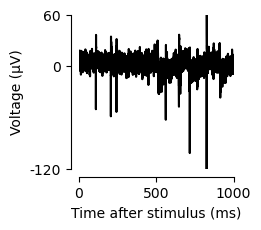

In [22]:
%%time 

# parameters
LAYER = 'L5'
STIM_START = 0
SITE_IX = 21
SFREQ = int(Recording.get_sampling_frequency())

# get one second trace to plot
onesecond = np.arange(STIM_START, STIM_START + SFREQ, 1).astype(int)
layers = Recording.get_property("layers")
L5_site = np.where(layers == LAYER)[0][SITE_IX]
fig_data = traces[onesecond, L5_site]

# plot
YMAX = 60
fig, ax = plt.subplots(1, 1, figsize=(2,2))

# plot figure
ax.plot(fig_data, color="k")

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time after stimulus (ms)")
ax.set_yticks([-120, 0, YMAX], [-120, 0, YMAX])
ax.set_ylim([-120, YMAX])
ax.set_xticks([0, SFREQ / 2, SFREQ], [0, 500, 1000])
ax.set_xlim([0, SFREQ])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# print background noise (min(MAD) over segments of 1 sec) here
wind_end = int(np.floor(len(traces)/SFREQ))
bkg_noise = noise.measure_trace_noise(traces[onesecond, L5_site], SFREQ, wind_end)

# report
print("nb of 1-sec windows:", len(bkg_noise))
print("Background noise level in uV (min MAD over windows):", min(bkg_noise))